# 测试环境

In [3]:
import torch

print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


# 基础数据操作

In [8]:
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

print(training_data.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Shape of X [batch, Channel, Height, Width]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


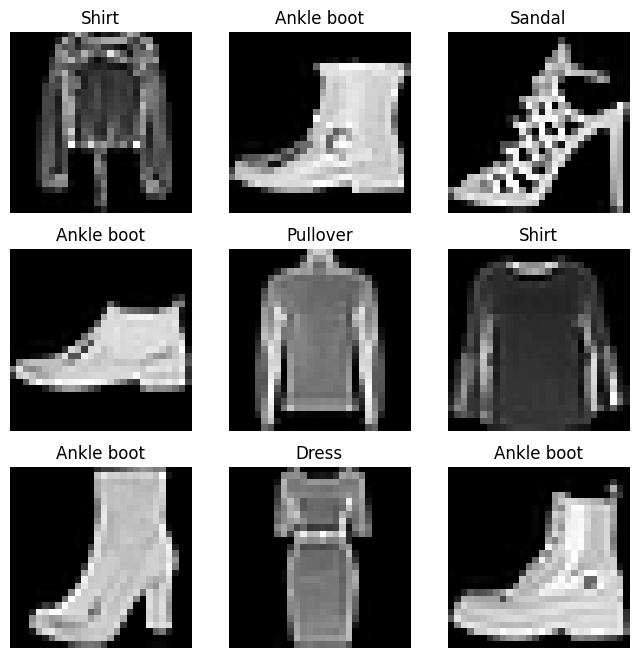

In [9]:
import matplotlib.pyplot as plt
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for x, y in test_dataloader:
    print(f"Shape of X [batch, Channel, Height, Width]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

labels_map = test_data.classes
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# 模型

In [53]:
device = (
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        # pre_probab = nn.Softmax(dim=1)(logits)
        # return pre_probab

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [54]:
one_x = x[0].unsqueeze(0).to(device)
print("one_x", one_x.shape)
pred_probab = model(one_x)
print("pred_probab", pred_probab.shape)
y_pred = pred_probab.argmax(1)
print(y_pred)

one_x torch.Size([1, 1, 28, 28])
pred_probab torch.Size([1, 10])
tensor([8], device='mps:0')


# 训练

In [55]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [56]:
def train(data_loader, model, loss_fn, optimizer):
    size = len(data_loader.dataset)
    model.train()
    for batch, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        # 计算损失函数
        pred = model(x)
        loss = loss_fn(pred, y)
        # Backpropagation, 计算梯度
        loss.backward()
        # 优化参数
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>4f}  [{current:>5d}/{size:>5d}]")


def test(data_loader, model, loss_fn):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss = loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [58]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 1.150914  [   64/60000]
loss: 1.154372  [ 6464/60000]
loss: 0.978097  [12864/60000]
loss: 1.110258  [19264/60000]
loss: 0.990473  [25664/60000]
loss: 1.012599  [32064/60000]
loss: 1.051734  [38464/60000]
loss: 0.986740  [44864/60000]
loss: 1.030879  [51264/60000]
loss: 0.965237  [57664/60000]
Test Error: 
 Accuracy: 66.2%, Avg loss: 0.005914 

Epoch 2
-------------------------------
loss: 1.033759  [   64/60000]
loss: 1.058295  [ 6464/60000]
loss: 0.864357  [12864/60000]
loss: 1.016431  [19264/60000]
loss: 0.903254  [25664/60000]
loss: 0.920279  [32064/60000]
loss: 0.975430  [38464/60000]
loss: 0.911576  [44864/60000]
loss: 0.952708  [51264/60000]
loss: 0.899048  [57664/60000]
Test Error: 
 Accuracy: 67.5%, Avg loss: 0.005243 

Epoch 3
-------------------------------
loss: 0.947331  [   64/60000]
loss: 0.992073  [ 6464/60000]
loss: 0.782888  [12864/60000]
loss: 0.950499  [19264/60000]
loss: 0.844876  [25664/60000]
loss: 0.853352  [32064/600

# 模型保存

In [61]:
torch.save(model.state_dict(), "data/test_1.model")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


# 模型加载

In [62]:
model_2 = NeuralNetwork().to(device)
model_2.load_state_dict(torch.load("data/test_1.model"))

<All keys matched successfully>

Predicted: "Sneaker", Actual: "Sneaker"


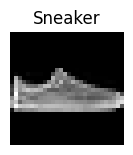

In [73]:
model_2.eval()
x, y = test_data[12]
img = x
with torch.no_grad():
    x = x.to(device)
    pred = model_2(x)
    predicted, actual = labels_map[pred[0].argmax(0)], labels_map[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

figure = plt.figure(figsize=(5, 5))
figure.add_subplot(rows, cols, i)
plt.title(labels_map[y])
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()